# Field Boundary Segmentation - SAM Exploration

This notebook demonstrates how to perform field boundary segmentation from satellite imagery (in this particular case, Sentinel-2).
This is an exploratory notebook that leverages FarmVibes.AI to download Sentinel-2 imagery and runs [Segment Anything Model](https://github.com/facebookresearch/segment-anything) to perform field boundary segmentation.

**Note**: This notebook runs SAM on the output of a FarmVibes.AI workflow. If you are interested in running SAM as a workflow within the cluster, refer to the `sam_workflow.ipynb` notebook.

The notebook is divided into the following sections:

1. **Setup**: This section provides instructions for setting up the micromamba environment for FarmVibes.AI and Segment Anything Model, and importing the necessary libraries for the notebook.

2. **Sentinel-2 data download**: after setup, we define a location and time range, and download a Sentinel-2 image using FarmVibes.AI.

3. **Field boundary segmentation**: This section demonstrates how to use [Segment Anything Model](https://github.com/facebookresearch/segment-anything) to automatically generate masks for the fields in the image. In this example, we use the `ViT-H` SAM model, but also provide instructions for setting up other versions of SAM. Besides automatic field segmentation, we also show how to manually select points in the image as prompts for the segmentation.


## Setup

Before running the notebook, make sure to create a micromamba environment with all the required libraries that we will use in this notebook. We provide two micromamba environment files, `env_cpu.yml` and `env_gpu.yml`, for systems that may or may note have GPU support. The environments can be installed and activeted with the following commands in the terminal:

Without GPU support (CPU):

```bash
$ micromamba env create -f env_cpu.yaml
$ micromamba activate segment_anything_cpu
```

With GPU support:
```bash
$ micromamba env create -f env_gpu.yaml
$ micromamba activate segment_anything
```

### Imports

In [1]:
%matplotlib widget

from datetime import datetime

import geopandas as gpd
import matplotlib.pyplot as plt
import notebook_lib.utils as utils
import numpy as np
import shapely.geometry as shpg
import torch
from rasterio.features import shapes
from rasterio.plot import show
from segment_anything import SamAutomaticMaskGenerator, SamPredictor, sam_model_registry

from vibe_core.client import get_default_vibe_client
from vibe_notebook.raster import read_raster, s2_to_img

-----------------------------

## Sentinel-2 data download with FarmVibes.AI

Let's define a location and time range to download data from. In this example, we select a small region around a defined latitude/longitude and a time range of a few days.

In [2]:
geometry = shpg.Point(-119.21896203939313, 46.44578909859286).buffer(0.05, cap_style=3)
time_range = (datetime(2020, 5, 1), datetime(2020, 5, 5))

We instantiate the FarmVibes.AI client and run the `data_ingestion/sentinel2/preprocess_s2` to download the imagery:

In [3]:
client = get_default_vibe_client()

run = client.run(
    "data_ingestion/sentinel2/preprocess_s2",
    "Sentinel-2 download",
    geometry=geometry,
    time_range=time_range,
)

run.monitor()

Output()

Once the workflow run completes, we will retrieve the output raster and visualize it: 

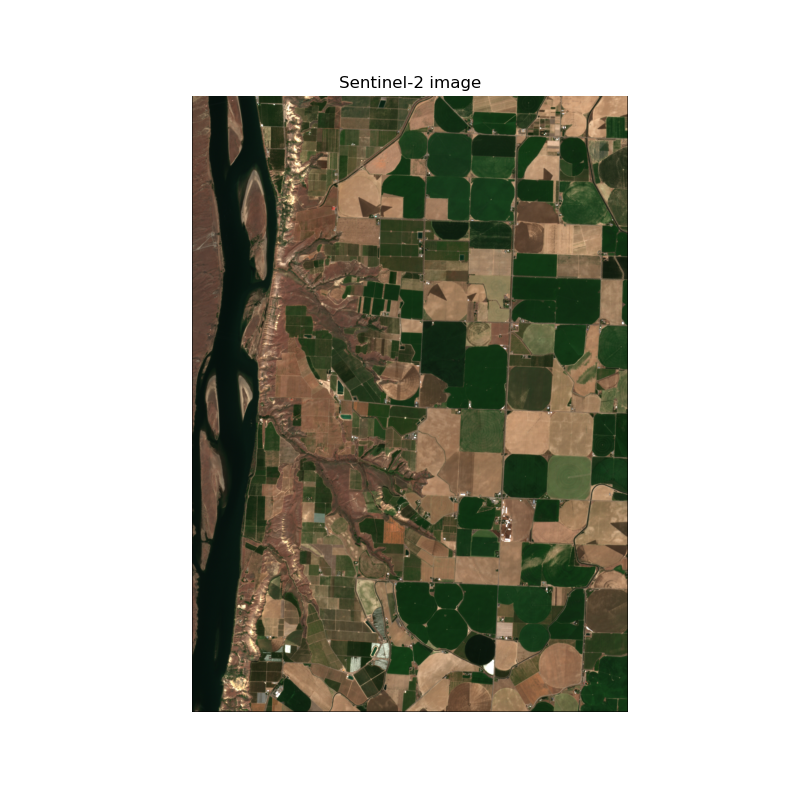

In [4]:
s2_raster = run.output["raster"][0]

ar, transform = read_raster(s2_raster, geometry)
img = s2_to_img(ar)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
show(img.transpose((2, 0, 1)), transform=transform, ax=ax)
ax.set_title("Sentinel-2 image")
ax.set_axis_off()

plt.show()

------------------------

## Field boundary segmentation

In this example, we will use [Segment Anything Model](https://github.com/facebookresearch/segment-anything), a promptable computer vision model that will help us segment the fields in the image.

We will start by downloading the model weights and setting up the model. We will use the ViT-H SAM model, but also provide instructions for setting up other versions of SAM.

### Segment-Anything setup

Before running the segmentation process, download one of the [model checkpoints available for SAM](https://github.com/facebookresearch/segment-anything#model-checkpoints) and place them under the `./models` folder:

In [ ]:
! wget -c -P ./models/ https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

**IMPORTANT**: Make sure to define the name and path to the checkpoint in the `model_name` and `model_path` variables:

In [5]:
model_name = "vit_h"  # one of "vit_h", "vit_l", "vit_b"
model_path = "./models/sam_vit_h_4b8939.pth"  # change the path accordingly

With weights downloaded, we can now instantiate the model itself. 

In [6]:
sam = sam_model_registry[model_name](checkpoint=model_path)
sam.to(device="cuda" if torch.cuda.is_available() else "cpu")

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

### Preprocess input image for SAM

SAM expects our image to be shaped as `HEIGHT` x `WIDTH` x `CHANNEL`, with pixel values within the `[0, 255]` interval. In this sense, let's preprocess the input image before feeding it to SAM: 

In [7]:
sam_input_img = (img * 255.0).astype(np.uint8)  # HWC, [0, 255]
print("Input image dimensions: ", sam_input_img.shape)
print(f"Min - Max values: [{np.min(sam_input_img)} , {np.max(sam_input_img)}] ")

Input image dimensions:  (1134, 801, 3)
Min - Max values: [0 , 255] 


### Automatic Mask Generation

Let's start by running the automatic mask generation process over our Sentinel-2 image. This will prompt SAM with multiple points (defined by the `points_per_side` argument) in the image, generating multiple masks that are filtered and combined to generate the final field masks. 

In [8]:
mask_generator = SamAutomaticMaskGenerator(sam, points_per_side=32)
automatic_masks = mask_generator.generate(sam_input_img)

Let's plot the generated masks:

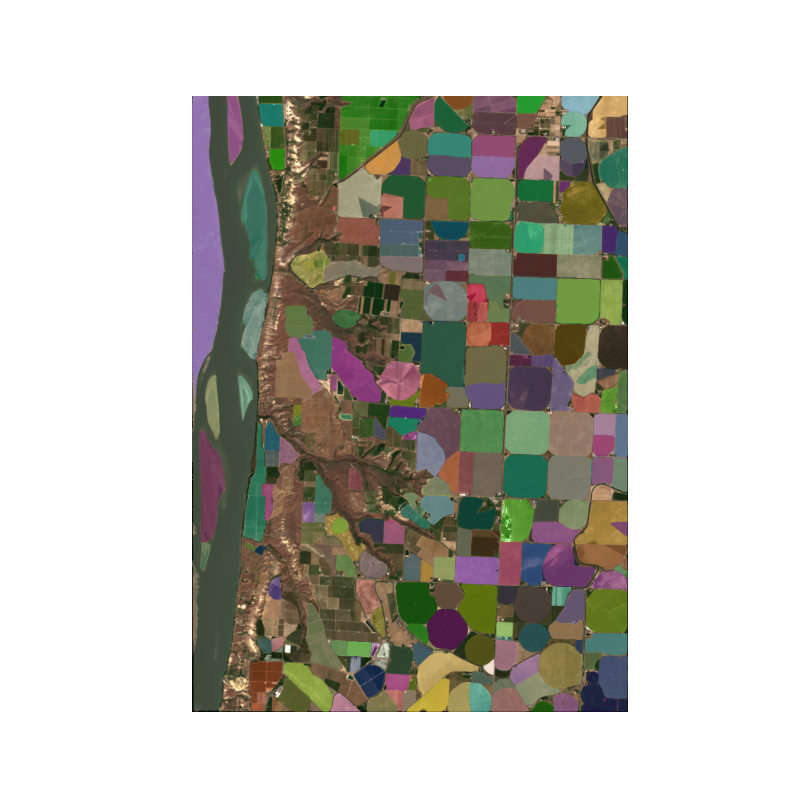

In [9]:
plt.figure(figsize=(8, 8))
plt.imshow(sam_input_img)
utils.show_anns(automatic_masks)
plt.axis("off")
plt.show()

We can also extract the boundaries of each mask/field:

In [10]:
automatic_masks_polygons = [
    shpg.shape(s[0])
    for m in automatic_masks
    for s in shapes(m["segmentation"].astype(np.uint8), mask=m["segmentation"], transform=transform)
]
automatic_masks_geoseries = gpd.GeoSeries(automatic_masks_polygons)

plt.figure(figsize=(10, 10))
ax = plt.gca()
automatic_masks_geoseries.boundary.plot(ax=ax, color="C0")

<AxesSubplot: >

If desired, we can also export the generated masks to a GeoJSON file:

In [11]:
automatic_masks_geoseries.to_file("automatic_masks.geojson", driver="GeoJSON")

As we can see, for our example image, the automatic segmentation was able to generate masks for most of the fields in the image. However, the river in the left side of the image and a few smaller fields were not segmented correctly. In the next section, we will show how to manually select foreground and background points in the image to help SAM generate better masks.

### Manual prompt selection

Let's use the visual interface of matplotlib and jupyter notebook to select points in the image that will be used as prompts for SAM. We will create a prompt for each field that we want to segment. For each prompt/field, we will select points in the image that are either foreground (i.e., points inside the desired field) or background (i.e., points outside the field).

The following keys are used to select points:

- Press `'f'` to add a new foreground point to the current prompt.
- Press `'b'` to add a new background point to the current prompt.
- Press `'n'` to save the current prompt and start a new one.
- Press `'e'` to exit the prompt selection process.

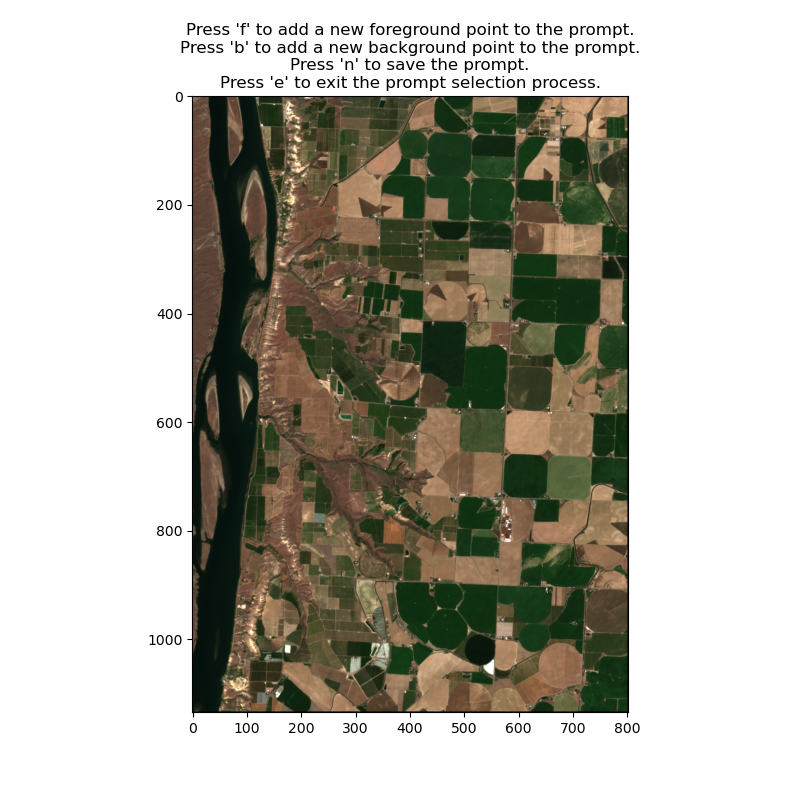

No such comm: 04450781533044ab8f87fd96eba95bf0
No such comm: 04450781533044ab8f87fd96eba95bf0


In [12]:
prompts = []
current_prompt = []
current_labels = []

fig = plt.figure(figsize=(8, 8))
next_obj_cid = fig.canvas.mpl_connect(
    "key_press_event",
    lambda e: utils.key_press(e, current_prompt, current_labels, prompts, sam_input_img),
)
plt.title(utils.MANUAL_PROMPT_TITLE)
imgplot = plt.imshow(sam_input_img)
plt.show()

Let's see how many prompts we have selected:

In [13]:
print(f"Number of prompts/fields: {len(prompts)}\n")
for n, elem in enumerate(prompts):
    prompt, labels = elem
    print(f"Prompt {n}: {len(prompt)} foreground/background points")
    print(f"\t Foreground: {[prompt[i] for i in range(len(prompt)) if labels[i] == 1]}")
    print(f"\t Background: {[prompt[i] for i in range(len(prompt)) if labels[i] == 0]}\n")

Number of prompts/fields: 3

Prompt 0: 1 foreground/background points
	 Foreground: [(534.3863636363635, 513.1136363636363)]
	 Background: []

Prompt 1: 1 foreground/background points
	 Foreground: [(613.5454545454545, 704.5681818181818)]
	 Background: []

Prompt 2: 4 foreground/background points
	 Foreground: [(460.74999999999994, 977.0227272727273)]
	 Background: [(405.5227272727272, 938.3636363636363), (530.7045454545455, 947.5681818181818), (473.63636363636357, 919.9545454545455)]



Now let's instantiate the SAM predictor and assign our input image to it. As we will run several prompts across the same image, SAM only needs to process the image a single time.

In [14]:
predictor = SamPredictor(sam)
predictor.set_image(sam_input_img)

Finally, let's run all our prompts and generate the masks:

In [15]:
manually_selected_masks = None

for prompt, labels in prompts:
    points_tensor = torch.tensor(np.array(prompt).reshape((1, -1, 2)), device=predictor.device)
    label_tensor = torch.tensor(np.array(labels).reshape((1, -1)), device=predictor.device)

    transformed_points = predictor.transform.apply_coords_torch(
        points_tensor, sam_input_img.shape[:2]
    )

    batch_masks, _, _ = predictor.predict_torch(
        point_coords=transformed_points,
        point_labels=label_tensor,
        multimask_output=False,
    )

    manually_selected_masks = (
        batch_masks
        if manually_selected_masks is None
        else torch.cat((manually_selected_masks, batch_masks))
    )

Let's plot the masks:

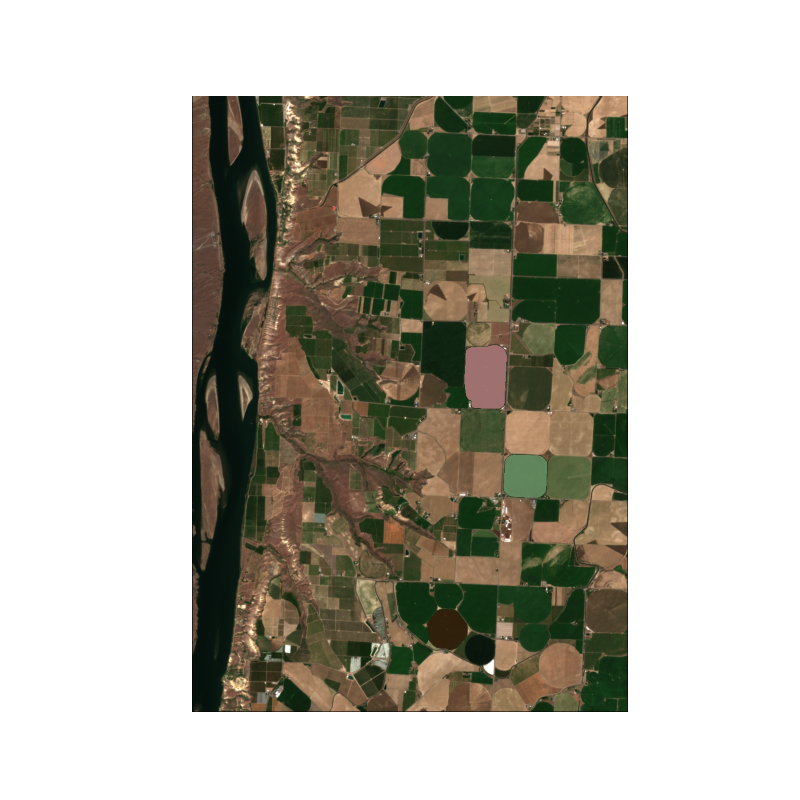

In [16]:
plt.figure(figsize=(8, 8))
plt.imshow(sam_input_img)
for mask in manually_selected_masks:
    utils.show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
plt.axis("off")
plt.show()

We can also extract the contours of each segmented field and plot them:

<AxesSubplot: >

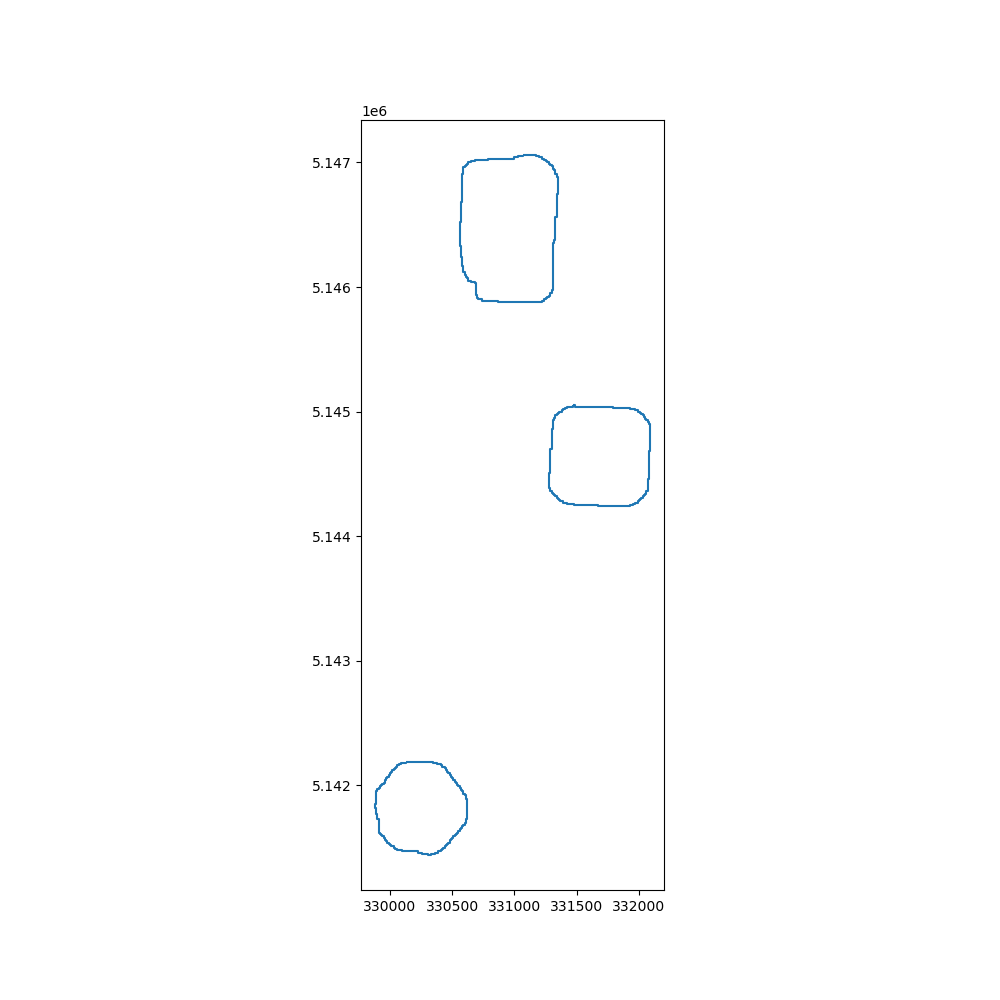

In [17]:
mask_arrays = [np.array(mask.cpu(), dtype=np.uint8)[0] for mask in manually_selected_masks]

manually_selected_masks_polygons = [
    shpg.shape(s[0]) for m in mask_arrays for s in shapes(m, mask=m, transform=transform)
]
manually_selected_masks_geoseries = gpd.GeoSeries(manually_selected_masks_polygons)

plt.figure(figsize=(10, 10))
ax = plt.gca()
manually_selected_masks_geoseries.boundary.plot(ax=ax, color="C0")

Similarly, these can be exported to a GeoJSON file:

In [ ]:
manually_selected_masks_geoseries.to_file("manually_selected_masks.geojson", driver="GeoJSON")